# PARITY-DEPENDENT QUANTUM PHASE TRANSITION IN THE QUANTUM ISING CHAIN
## Numerical Simulation 
### Advanced Quantum Mechanics - Group: Antonio Francesco Mello, Asian Selvakumaran, Federico Raffaele De Filippi, Francesco Proietto

In [ ]:
# importing libraries 
import numpy as np
from uncertainties import ufloat
from numpy import exp

# standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.providers.aer import AerSimulator
from qiskit.opflow import Z,I,X
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA,  COBYLA
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator 
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
import matplotlib.pyplot as plt

# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel
# Import all standard errors
from qiskit.providers.aer.noise.errors import *  
# Import noise base classes
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## FUNCTIONS DEFINITION

In [ ]:
#function generating the hamiltonian for a TFIM with nn interaction Ji and field hf - PBC
def ham_generator(N,h,J):
    H=0
    
    # field term
    for i in range (N):
        H+= h*((I^(i))^(Z)^(I^(N-i-1))) 
    # interaction term
    for k in range(N-1):
        H+= J*((I^(k))^(X^X)^(I^(N-k-2)))
    # PBC
    H+= J*((X)^(I^(N-2))^(X))           
    return H         


#function that calculates the central difference derivative
# given npoints values of h in the interval [a,b[
def cd_derivative(a,b,en,npoints): 
    
    step = (b-a)/npoints 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    cd = (en[z+1]-en[z-1])/(2*step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h) in h = 0 >>', cd)
    return 

#function that calculates the forward derivative
def f_derivative(a,b,en,npoints):

    step = (b-a)/npoints 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    fd = (en[z+1]-en[z])/(step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h), h->0+ >>', fd)
    return fd


#function that calculates the backward derivative
def b_derivative(a,b,en,npoints):

    step = (b-a)/npoints 
    for i in range(npoints):
        if a + i*step == 0:
            print('zero found in position >>', i)
            z=i
            break
    bd = (en[z]-en[z-1])/(step)
    
    print('spacing used to calculate the derivative >> ', step)
    print('numerical derivative of E(h), h->0- >>', bd)
    return bd

#intermediate_info and callback function
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}



def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)


#function initializing intermediate_info
def clear_info():
    info_f = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    return info_f

np.random.seed(7) #seed for reproducibility

In [ ]:
#parameters definition
nqubits=5
h=0.2
J=1.

In [ ]:
# THERMAL RELAXATION ERROR

# each qubit is parametrized by two times: T1 and T2 which are respectively:
# - Relaxation time -> tendency of the state 1 to relax to 0
# - Dephasing time -> time required for each qubit to approach the z axis

def thermal_rel():
    # T1 and T2 values for qubits 0-(nqubits-1)
    T1s = np.random.normal(50e3, 10e3, nqubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, nqubits)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s in order to make it <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(nqubits)]) 

    # Instruction times (in nanoseconds) -> gate time: time required to execute gate instruction
    time_u1 = 0   # virtual gate -> it is a z rotation
    time_u2 = 50  # (single X90 pulse) -> single qubit double rotation x and z
    time_u3 = 100 # (two X90 pulses) -> single qubit rotation parametrized by three euler angles
    time_cx = 300
    time_reset = 1000  
    time_measure = 1000 
 
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                      for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                  for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).tensor(
                 thermal_relaxation_error(t1b, t2b, time_cx))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(nqubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(nqubits):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

    print(noise_thermal)
    return noise_thermal

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'cx', 'measure', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (2, 4)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3)), ('cx', (3, 4)), ('cx', (4, 0)), ('cx', (4, 1)), ('cx', (4, 2)), ('cx', (4, 3)), ('cx', (4, 4))]


/tmp/ipykernel_59/1285787597.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/1285787597.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_59/1285787597.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue


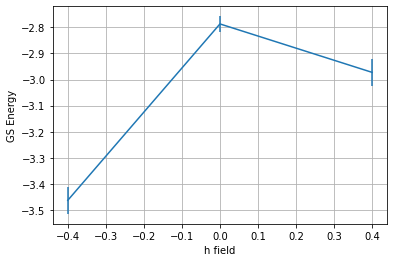

In [ ]:
# Quantum Phase Transition Study - Thermal relaxation noise simulation
# 0DD PARITY SECTOR
npme = NumPyMinimumEigensolver()
nqubits=5
thermal_model=thermal_rel()
sim_noise = AerSimulator(noise_model=thermal_model)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = [-0.4,0.,0.4] #chosen values of h to study the QPT with the presence of noise
energy_5 = np.zeros(len(h))
y_err = np.zeros(len(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(len(h)):
    
    H5 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=thermal_model),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy_5[j] = local_result.eigenvalue
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_5,yerr=y_err,label='VQE evaluation')

plt.grid()
plt.show()

In [ ]:
print(energy_5)

[-3.4625     -2.78710938 -2.97265625]


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'cx', 'measure', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (0, 5)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (1, 5)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (2, 4)), ('cx', (2, 5)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3)), ('cx', (3, 4)), ('cx', (3, 5)), ('cx', (4, 0)), ('cx', (4, 1)), ('cx

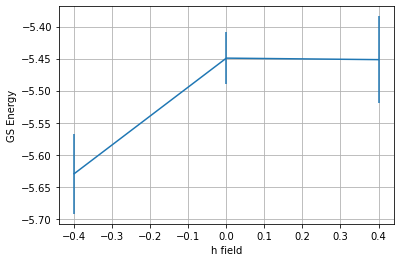

In [ ]:
# EVEN PARITY SECTOR
npme = NumPyMinimumEigensolver()
nqubits=6
thermal_model=thermal_rel()
sim_noise = AerSimulator(noise_model=thermal_model)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = [-0.4,0.,0.4] #chosen values of h to study the QPT with the presence of noise
energy_6 = np.zeros(len(h))
y_err = np.zeros(len(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(len(h)):
    
    H6 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=thermal_model),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H6)
    energy_6[j] = np.real(local_result.eigenvalue)
    y_err[j]=intermediate_info['stddev'][-1] 
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_6,yerr=y_err,label='VQE evaluation')

plt.grid()
plt.show()

In [ ]:
print(energy_6)

[-5.6296875  -5.44921875 -5.4515625 ]


In [ ]:
# DERIVATIVES EVALUATION
even_dx=(energy_6[2]-energy_6[1])/0.4
even_sx=(energy_6[1]-energy_6[0])/0.4
print('Even parity sector derivative >> ', even_dx-even_sx)
odd_dx=(energy_5[2]-energy_5[1])/0.4
odd_sx=(energy_5[1]-energy_5[0])/0.4
print('Odd parity sector derivative >> ', odd_dx - odd_sx)

Even parity sector derivative >>  -0.45703124999999956
Odd parity sector derivative >>  -2.152343750000001


In [ ]:
#IBM noise model with depolarization, relaxation after gates and bit-flip

def IBM_noise_model(backend,qubits_layout):
    
    tg = 35 * 10**(-9) # gate time
    
    nqubit = len(qubits_layout)
    
    noise_model = NoiseModel()
    
    prop = backend.properties()
    
    t_cnot = np.zeros((nqubit,nqubit))
        
    p_cnot = np.zeros((nqubit,nqubit))
    
    
    #Read from backend

    T1 = [prop.t1(j) for j in qubits_layout]
    T2 = [prop.t2(j) for j in qubits_layout]
    p = [prop.gate_error('x',[j]) for j in qubits_layout]
    rout = [prop.readout_error(j) for j in qubits_layout]

    if (nqubit > 1):
        for i in range(0,nqubit):
            if (i == 0):
                t_cnot[0][1] = prop.gate_length('cx',[qubits_layout[0],qubits_layout[1]])
                p_cnot[0][1] = prop.gate_error('cx',[qubits_layout[0],qubits_layout[1]])
            if (i != 0 and i != nqubit-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                t_cnot[i][i+1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i+1]])
                p_cnot[i][i+1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i+1]])
            if (i == nqubit-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
    
   
        
    for j in range(0,nqubit):
        
        #single qubit depolarizing
        
        dep = depolarizing_error(p[j],1)
        
        #single qubit relaxation
        
        Tph = T1[j] * T2[j] / (2 * T1[j] - T2[j])
        p1 = 1 - exp(-tg/T1[j])
        p_ph = 1 - exp(-tg/Tph)
        pz = (1 - p1) * p_ph
          
        relax = phase_amplitude_damping_error(p1,pz)
        
        # pauli X error          
        spam = pauli_error([('X',rout[j]), ('I', 1 - rout[j])])
        
        #adding errors to noise model
        
        single_qubit_gate_error = dep.compose(relax)
        
        noise_model.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        
        noise_model.add_quantum_error(spam, "measure",[qubits_layout[j]])
        

        
    for j in range(0,nqubit):
        for k in range(0,nqubit):
            if (k == j+1 or k == j-1):
                
                #two qubits relaxation
            
                Tph_j = T1[j] * T2[j] / (2 * T1[j] - T2[j])
                p1_j = 1 - exp(-t_cnot[j][k]/T1[j])
                p_ph_j = 1 - exp(-t_cnot[j][k]/Tph_j)
                pz_j = (1 - p1_j) * p_ph_j
                
                Tph_k = T1[k] * T2[k] / (2 * T1[k] - T2[k])
                p1_k = 1 - exp(-t_cnot[j][k]/T1[k])
                p_ph_k = 1 - exp(-t_cnot[j][k]/Tph_k)
                pz_k = (1 - p1_k) * p_ph_k
        
                relax_j = phase_amplitude_damping_error(p1_j,pz_j)
                relax_k = phase_amplitude_damping_error(p1_k,pz_k)
                relax_jk = relax_k.tensor(relax_j)
   
                
                #two qubits depolarizing
                
                dep_j = depolarizing_error(p_cnot[j][k],1)
                dep_k = depolarizing_error(p_cnot[j][k],1)
                dep_cnot = dep_k.tensor(dep_j) 
                
                #adding errors to noise model
                
                two_qubits_gate_error = dep_cnot.compose(relax_jk)
                
                noise_model.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
                
    print('t_cnot:',t_cnot)
    print('p_cnot:',p_cnot)
    print('T1:',T1)
    print('T2:',T2)
    print('p:',p)
    print('rout:',rout)
    return noise_model

In [ ]:
IBMQ.delete_account()
Token = '6d37dcb82419b3d0715e180cc619e6714bca8646b86cf69f54bcc756743eb8c71219a9ea2dfa468f7d1dae7663e9b0ab7d053d98fccc169aa7a15cc0ce914aaa'
IBMQ.save_account(Token)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()

backend = provider.get_backend("ibm_oslo")
plot_gate_map(backend)
qubits_layout=[0,1,3,5,6]
ibm_noise=IBM_noise_model(backend,qubits_layout)
print(ibm_noise)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'measure', 'x', 'sx']
  Qubits with noise: [0, 1, 3, 5, 6]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (3,)), ('x', (5,)), ('x', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (3,)), ('sx', (5,)), ('sx', (6,)), ('measure', (0,)), ('measure', (1,)), ('measure', (3,)), ('measure', (5,)), ('measure', (6,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (3, 5)), ('cx', (5, 3)), ('cx', (5, 6)), ('cx', (6, 5))]


/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_5[j] = local_result.eigenvalue
/tmp/ipykernel_93/4282000097.py:28: ComplexWarning: Casting complex values to real discards th

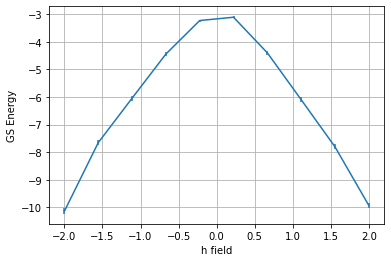

In [ ]:
# VQE GS ENERGY EVALUATION WITH VARYING MAGNETIC FIELD
# 0DD PARITY SECTOR
npme = NumPyMinimumEigensolver()
nqubits=5
sim_noise = AerSimulator(noise_model=ibm_noise)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = np.linspace(-2,2,10) #chosen values of h to study the QPT with the presence of noise
energy_5 = np.zeros(len(h))
y_err = np.zeros(len(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(len(h)):
    
    H5 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=ibm_noise),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy_5[j] = local_result.eigenvalue
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_5,yerr=y_err,label='VQE evaluation')

plt.grid()
plt.show()

In [ ]:
print(energy_5)

[-10.13671875  -7.65364583  -6.04210069  -4.44140625  -3.22699653
  -3.10677083  -4.39713542  -6.09418403  -7.80338542  -9.92578125]


In [ ]:
# DERIVATIVES EVALUATION
even_dx = f_derivative(-2,2,energy_5,10)
even_sx = b_derivative(-2,2,energy_5,10)
print('Odd parity sector derivative >> ', even_dx-even_sx)
# in the even parity sector the derivative exists

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -3.2259114583333313
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> 0.3005642361111116
Odd parity sector derivative >>  -3.526475694444443


In [ ]:
IBM_noise_model(backend,qubits_layout)

t_cnot: [[0.00000000e+00 3.41333333e-07 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.12444444e-07 0.00000000e+00 3.76888889e-07 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.12444444e-07 0.00000000e+00 2.38222222e-07
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.67111111e-07 0.00000000e+00
  4.05333333e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.34222222e-07
  0.00000000e+00]]
p_cnot: [[0.         0.00772511 0.         0.         0.        ]
 [0.00772511 0.         0.00972714 0.         0.        ]
 [0.         0.00972714 0.         0.00526535 0.        ]
 [0.         0.         0.00526535 0.         0.00747128]
 [0.         0.         0.         0.00747128 0.        ]]
T1: [0.0001327154544706413, 0.00017375073072474782, 8.829103572384231e-05, 0.00010916569948968134, 0.00013536117528431294]
T2: [0.00015833918001215141, 3.070124340580053e-05, 3.217539799672105e-05, 3.188331592878536e-05, 0.0002536360517313913]
p: [0.0001631730528065976, 0.0002354560506894706

<NoiseModel on ['cx', 'measure', 'x', 'sx']>

In [ ]:
IBMQ.delete_account()
Token = '6d37dcb82419b3d0715e180cc619e6714bca8646b86cf69f54bcc756743eb8c71219a9ea2dfa468f7d1dae7663e9b0ab7d053d98fccc169aa7a15cc0ce914aaa'
IBMQ.save_account(Token)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()

backend = provider.get_backend("ibm_oslo")
plot_gate_map(backend)
qubits_layout=[0,1,3,5]
ibm_noise=IBM_noise_model(backend,qubits_layout)
print(ibm_noise)

ibmqfactory.load_account:WARNING:2023-01-08 11:45:42,811: Credentials are already in use. The existing account in the session will be replaced.


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'cx', 'measure']
  Qubits with noise: [0, 1, 3, 5]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (3,)), ('x', (5,)), ('sx', (0,)), ('sx', (1,)), ('sx', (3,)), ('sx', (5,)), ('measure', (0,)), ('measure', (1,)), ('measure', (3,)), ('measure', (5,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (3, 5)), ('cx', (5, 3))]


/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  energy_4[j] = local_result.eigenvalue
/tmp/ipykernel_59/1776159353.py:29: ComplexWarning: Casting complex values to real discards th

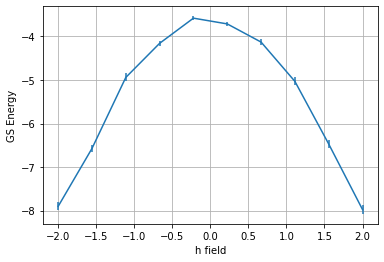

In [ ]:
# VQE GS ENERGY EVALUATION WITH VARYING MAGNETIC FIELD
# 0DD PARITY SECTOR
J=1.0
npme = NumPyMinimumEigensolver()
nqubits=4
sim_noise = AerSimulator(noise_model=ibm_noise)
ansatz=EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=True) 

transpiled_ansatz=transpile(ansatz, sim_noise)
h = np.linspace(-2,2,10) #chosen values of h to study the QPT with the presence of noise
energy_4 = np.zeros(len(h))
y_err = np.zeros(len(h))
initial_point = np.random.random(ansatz.num_parameters)
optimizer=SPSA(maxiter=2000)

    
for j in range(len(h)):
    
    H5 = ham_generator(nqubits,h[j],J)
    
    clear_info()
    
    local_vqe = VQE(ansatz=transpiled_ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=AerSimulator(noise_model=ibm_noise),
                callback=callback)
    local_result = local_vqe.compute_minimum_eigenvalue(H5)
    energy_4[j] = local_result.eigenvalue
    y_err[j]=intermediate_info['stddev'][-1] # for the standard deviation on energy with different values of h 
plt.xlabel('h field')
plt.ylabel('GS Energy')
plt.errorbar(h,energy_4,yerr=y_err,label='VQE evaluation')

plt.grid()
plt.show()

In [ ]:
print(energy_4)

[-7.90234375 -6.57248264 -4.94097222 -4.15755208 -3.57942708 -3.71180556
 -4.12890625 -5.03168403 -6.47048611 -7.9765625 ]


In [ ]:
# DERIVATIVES EVALUATION
even_dx = f_derivative(-2,2,energy_4,10)
even_sx = b_derivative(-2,2,energy_4,10)
print('Even parity sector derivative >> ', even_dx-even_sx)
# in the even parity sector the derivative exists

zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0+ >> -1.0427517361111127
zero found in position >> 5
spacing used to calculate the derivative >>  0.4
numerical derivative of E(h), h->0- >> -0.3309461805555536
Even parity sector derivative >>  -0.7118055555555591
